In [1]:
from PIL import Image
import imagehash
import os
import pandas as pd
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
import pickle
import plotly.graph_objects as go
import plotly.subplots as sp
import base64
import os
DATA_DIR = os.path.expanduser('~/data')

In [2]:
def save_images(dataset, save_dir):
    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        img = transforms.ToPILImage()(img)  # Convert tensor to PIL image
        img.save(os.path.join(save_dir, f'{label}_{i}.png'))

In [3]:
def compute_hashes(image_paths:pd.Series) -> dict:
    d_idx_hash = {}
    for idx,image in image_paths.itteritems():
        hash_image = imagehash.average_hash(Image.open(image))
        d_idx_hash[idx] = hash_image
    return d_idx_hash

# Download and Save CIFAR-10/100 Images

In [4]:
# Download CIFAR10/100 images
cifar_dir = os.path.join(DATA_DIR, 'data_cifar')
os.makedirs(cifar_dir, exist_ok=True)
transform = transforms.ToTensor()
cifar10_train_ds = CIFAR10(cifar_dir, download=True, train=True, transform=transform)
cifar100_train_ds = CIFAR100(cifar_dir, download=True, train=True, transform=transform)

In [5]:
cifar10_images_path = os.path.join(DATA_DIR, 'data_cifar', 'images_cifar10')
if not os.path.exists(cifar10_images_path):
    os.makedirs(cifar10_images_path, exist_ok=True)
    save_images(cifar10_train_ds, cifar10_images_path)

cifar100_images_path = os.path.join(DATA_DIR, 'data_cifar', 'images_cifar100')
if not os.path.exists(cifar100_images_path):
    os.makedirs(cifar100_images_path, exist_ok=True)
    save_images(cifar100_train_ds, cifar100_images_path)

# Compute and store Perceptual Hashes (pHashes)

In [6]:
def compute_and_store_hashes(image_folder, hash_function=imagehash.phash, output_file='image_hashes.pkl'):
    image_hashes = {}

    for filename in tqdm(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)
            hash_value = hash_function(image)
            image_hashes[filename] = hash_value
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Save the hashes to a file
    with open(output_file, 'wb') as f:
        pickle.dump(image_hashes, f)

In [7]:
if not os.path.exists("cifar10_image_hashes.pkl"):
    compute_and_store_hashes(cifar10_images_path, output_file='cifar10_image_hashes.pkl')
if not os.path.exists("cifar100_image_hashes.pkl"):
    compute_and_store_hashes(cifar100_images_path, output_file='cifar100_image_hashes.pkl')

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [8]:
import random

cifar_10_hashes = pd.read_pickle('cifar10_image_hashes.pkl')
cifar_100_hashes = pd.read_pickle('cifar100_image_hashes.pkl')


class_labels = [int(filename.split('_')[0]) for filename in cifar_10_hashes.keys()]
unique_classes = list(set(class_labels))
cifar10_forget = {}
cifar10_retain = {}
random_500_instances_per_class = []
for class_label in unique_classes:
    instances = [filename for filename, label in zip(cifar_10_hashes.keys(), class_labels) if label == class_label]
    random_instances = random.sample(instances, 500)
    random_500_instances_per_class.extend(random_instances)
for filename in cifar_10_hashes.keys():
    if filename in random_500_instances_per_class:
        cifar10_forget[filename] = cifar_10_hashes[filename]
    else:
        cifar10_retain[filename] = cifar_10_hashes[filename]

# Randomly select 500 instances from each class
class_labels = [int(filename.split('_')[0]) for filename in cifar_100_hashes.keys()]
unique_classes = list(set(class_labels))
cifar100_forget = {}
cifar100_retain = {}
random_50_instances_per_class = []
for class_label in unique_classes:
    instances = [filename for filename, label in zip(cifar_100_hashes.keys(), class_labels) if label == class_label]
    random_instances = random.sample(instances, 50)
    random_50_instances_per_class.extend(random_instances)
for filename in cifar_100_hashes.keys():
    if filename in random_50_instances_per_class:
        cifar100_forget[filename] = cifar_100_hashes[filename]
    else:
        cifar100_retain[filename] = cifar_100_hashes[filename]

print(len(cifar10_forget), len(cifar10_retain), len(cifar100_forget), len(cifar100_retain))

5000 45000 5000 45000


# Find Similar Images

In [9]:
def load_pickle(input_file):
    with open(input_file, 'rb') as f:
        image_hashes = pickle.load(f)
    return image_hashes

# MUFAC

In [10]:
mufac_clean_dir = os.path.join(DATA_DIR, 'custom_korean_family_dataset_resolution_128_clean')
mufac_clean_train_csv = os.path.join(mufac_clean_dir, 'custom_train_dataset.csv')
df_train_clean = pd.read_csv(mufac_clean_train_csv)
df_forget = df_train_clean[:1062]
df_retain = df_train_clean[1062:]
df_forget.head()

,family_id,person_id,age_class,image_path
0,F0001,D,a,F0001_AGE_D_18_a1.jpg
1,F0001,D,a,F0001_AGE_D_18_a2.jpg
2,F0001,D,a,F0001_AGE_D_18_a3.jpg
3,F0001,D,a,F0001_AGE_D_18_a4.jpg
4,F0001,D,b,F0001_AGE_D_18_b1.jpg


In [11]:
def compute_and_store_hashes_clean(image_folder, clean_image_filenames, hash_function=imagehash.phash, output_file='image_hashes.pkl'):
    image_hashes = {}

    for filename in tqdm(clean_image_filenames):
        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)
            hash_value = hash_function(image)
            image_hashes[filename] = hash_value
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Save the hashes to a file
    with open(output_file, 'wb') as f:
        pickle.dump(image_hashes, f)
    return image_hashes


In [12]:
mufac_forget_hashes_clean = (
    load_pickle("mufac_forget_hashes_clean.pkl")
    if os.path.exists("mufac_forget_hashes_clean.pkl")
    else compute_and_store_hashes_clean(
        os.path.join(mufac_clean_dir, "forget_images"),
        df_forget["image_path"].values,
        output_file="mufac_forget_hashes_clean.pkl",
    )
)

mufac_retain_hashes_clean = (
    load_pickle("mufac_retain_clean_hashes.pkl")
    if os.path.exists("mufac_retain_clean_hashes.pkl")
    else compute_and_store_hashes_clean(
        os.path.join(mufac_clean_dir, "retain_images"),
        df_retain["image_path"].values,
        output_file="mufac_retain_clean_hashes.pkl",
    )
)

  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/5513 [00:00<?, ?it/s]

In [13]:
def compute_and_store_hash_differences(image_hashes_forget, image_hashes_retain, output_file='hash_differences.pkl'):
    forget_hashes = list(image_hashes_forget.values())
    retain_hashes = list(image_hashes_retain.values())
    hash_diffs = []
    
    for forget_hash in tqdm(forget_hashes):
        for  retain_hash in retain_hashes:
            hash_diff = abs(forget_hash - retain_hash)
            hash_diffs.append(hash_diff)


    # Save the differences to a file
    with open(output_file, 'wb') as f:
        pickle.dump(hash_diffs, f)

    return hash_diffs

In [14]:
mufac_forget_retain_pairs = (
    load_pickle("mufac_forget_retain_hash_differences.pkl")
    if os.path.exists("mufac_forget_retain_hash_differences.pkl")
    else compute_and_store_hash_differences(
        mufac_forget_hashes_clean,
        mufac_retain_hashes_clean,
        output_file="mufac_forget_retain_hash_differences.pkl",
    )
)

cifar10_forget_retain_pairs = (
    load_pickle("cifar10_forget_retain_hash_differences.pkl")
    if os.path.exists("cifar10_forget_retain_hash_differences.pkl")
    else compute_and_store_hash_differences(
        cifar10_forget,
        cifar10_retain,
        output_file="cifar10_forget_retain_hash_differences.pkl",
    )
)

cifar_100_forget_retain_pairs = (
    load_pickle("cifar100_forget_retain_hash_differences.pkl")
    if os.path.exists("cifar100_forget_retain_hash_differences.pkl")
    else compute_and_store_hash_differences(
        cifar100_forget,
        cifar100_retain,
        output_file="cifar100_forget_retain_hash_differences.pkl",
    )
)

  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Checking orthogonality of the of retain - forget set

In [15]:
import random 
random.seed(42)
print(f"len(mufac_forget_retain_pairs)) {len(mufac_forget_retain_pairs)}")
print(f"len(cifar10_forget_retain_pairs)) {len(cifar10_forget_retain_pairs)}")
print(f"len(cifar_100_forget_retain_pairs)) {len(cifar_100_forget_retain_pairs)}")


cifar10_sample = random.sample(cifar10_forget_retain_pairs, len(mufac_forget_retain_pairs))
cifar100_sample = random.sample(cifar_100_forget_retain_pairs, len(mufac_forget_retain_pairs))


len(mufac_forget_retain_pairs)) 5854806
len(cifar10_forget_retain_pairs)) 225000000
len(cifar_100_forget_retain_pairs)) 225000000


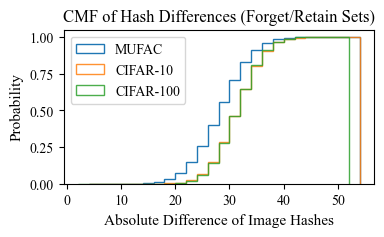

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(4, 2))
plt.hist(
    mufac_forget_retain_pairs,
    bins=100,
    alpha=1,
    label="MUFAC",
    density=True,
    cumulative=True,
    histtype="step",
)
plt.hist(
    cifar10_sample,
    bins=100,
    alpha=0.85,
    label="CIFAR-10",
    density=True,
    cumulative=True,
    histtype="step",    
)
plt.hist(
    cifar100_sample,
    bins=100,
    alpha=0.85,
    label="CIFAR-100",
    density=True,
    cumulative=True,
    histtype="step",    
)

plt.xlabel('Absolute Difference of Image Hashes', fontsize=11)
plt.ylabel('Probability',fontsize=11)
plt.title('CMF of Hash Differences (Forget/Retain Sets)', fontsize=12)
plt.legend()
plt.savefig('images/cmf_hash_differences.png', dpi=300, bbox_inches='tight')
plt.show()